# Проект Промышленность. Разработка модели предсказания температуры стали для комбината "Стальная птица"

**План проекта**
1. Загрузка данных.
На данном этапе будет проведён первичный осмотр предоставленных данных;
2. Исследовательский анализ и предобработка данных.
Обработка пропусков, дубликатов, рассмотрение характера распределения данных, определение ключа для объединения дата-файлов;
3. Объединение дата-файлов.
4. Анализ и предобработка объединенного дата-файла.
5. Подготовка данных.
Здесь необъодимо провести разбинение данных на две выборки;
6. Обучение моделей машинного обучения.
Обучить минимум две модели. Хотя бы для одной подобрать минимум 2 гиперпараметра;
7. Выбрать лучшую модель и обучить её на тестовой выборке.
8. Сделать общие выводы и дать рекомендации заказчику.

Прежде всего загружу необходимые библиотеки.

In [ ]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import  make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer
import time


Установлю модуль для анализа значимости признаков snap.

In [ ]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


Теперь подключу его.

In [ ]:
import shap

Кроме того, объявлю обозначенное ментором значение для генератора случайных чисел.

In [ ]:
RANDOM_STATE = 131123

И задам для расчётов

In [ ]:
cv_counts = 5

Теперь приступаю непосредственно к проекту.

## Загрузка данных

Не смотря на обилие файлов данных, я рассмотрю каждый по отдельности. Не буду использовать цикл.

### Данные об электродах

In [ ]:
try:
    arcs = pd.read_csv('/datasets/data_arc_new.csv')
except FileNotFoundError:
    arcs = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

Загрузил файл. Теперь взгляну на несколько первых и последних строк.

In [ ]:
arcs.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [ ]:
arcs.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


Получу информацию о файле.

In [ ]:
arcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков нет - уже хорошо. Бросается в глаза формат object для столбцов начало и конец нагрева дугой, но, с другой стороны, здесь показаны дата и время. У заказчика данные хранятся именно в таком порядке, значит ему так удобнее.

Проверю на дубликаты.

In [ ]:
arcs.duplicated().sum()

0

Дубликатов нет.

Для интереса гляну распределение значений активной мощности и реактивной мощности.

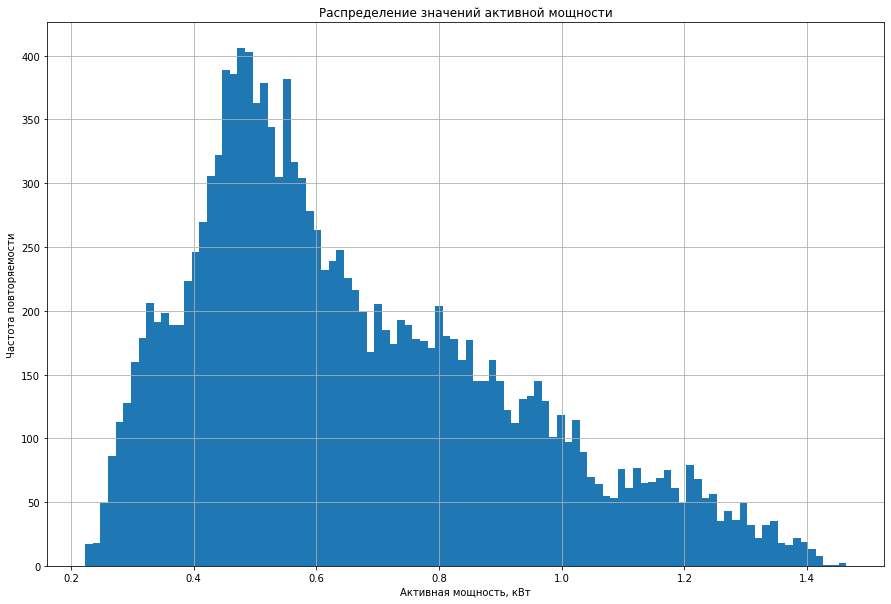

In [ ]:
arcs['Активная мощность'].hist(bins=100, figsize=(15,10))
plt.title('Распределение значений активной мощности')
plt.xlabel('Активная мощность, кВт')
plt.ylabel('Частота повторяемости')
plt.show()

Не совсем нормальное, смещённое распределение, но неплохо. Единицу измерения мощности предположил.

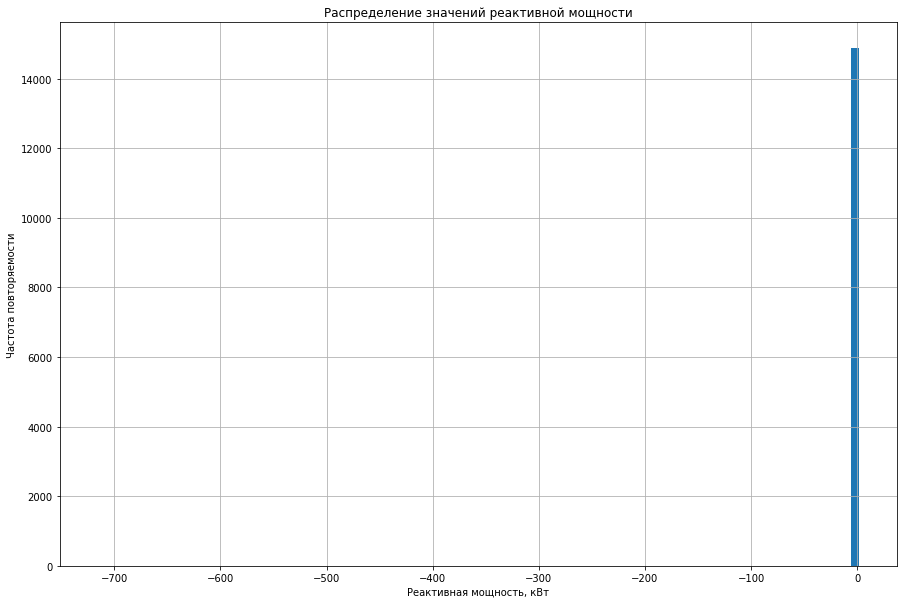

In [ ]:
arcs['Реактивная мощность'].hist(bins=100, figsize=(15,10))
plt.title('Распределение значений реактивной мощности')
plt.xlabel('Реактивная мощность, кВт')
plt.ylabel('Частота повторяемости')
plt.show()

Очень странно получилось... Всё отрицательно? Проверю руками, сколько строк имеют отрицательную мощность.

In [ ]:
arcs[arcs['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Всего одна... Тогда непонятно, что с графиком. В любом случае, отрицательное значение удалю на следующем этапе. И после этого ещё раз построю график.

In [ ]:
arcs.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


#### Промежуточные выводы по пункту 1.1

1. Загружен файл с данными об электродах;
2. Рассмотрены несколько первых и последних строк файла;
3. Столбцы проименованы по-русски, с заглавной буквы, с пробелами. Менять наименование пока не буду. Заказчика такой формат устраивает;
4. В данных о реактивной мощности присутствует отрицательное значение;
4. Пропусков и дубликатов не обнаружено.

### Данные о подаче сыпучих материалов (объём)

In [ ]:
try:
    bulk = pd.read_csv('/datasets/data_bulk_new.csv')
except FileNotFoundError:
    bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

Загрузил файл. Теперь взгляну на несколько первых и последних строк.

In [ ]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
bulk.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


Получу информацию о файле.

In [ ]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Наименование столбцов теперь по-английски. Видно, что существует определенное количество пропусков по столбцам. Проранжирую их по количеству пропусков.

In [ ]:
bulk.isna().sum().sort_values(ascending=False)

Bulk 8     3128
Bulk 13    3111
Bulk 9     3110
Bulk 2     3107
Bulk 7     3104
Bulk 5     3052
Bulk 10    2953
Bulk 11    2952
Bulk 1     2877
Bulk 6     2553
Bulk 4     2115
Bulk 3     1831
Bulk 15     881
Bulk 12     679
Bulk 14     323
key           0
dtype: int64

И проверю на наличие дубликатов.

In [ ]:
bulk.duplicated().sum()

0

Дубликатов нет.

#### Промежуточные выводы по пункту 1.2

1. Загружен файл с данными об объёме поданных сыпучих материалов;
2. Рассмотрены несколько первых и последних строк файла;
3. Столбцы проименованы по-английски, с заглавной буквы, с пробелами Менять наименование пока не буду. Заказчика такой формат устраивает;
3. Пропуски обнаружены во всех столбцах. Наибольшее количество - в столбце Объёмом 8 (Bulk 8). На следующем этапе пропуски заполню нулями. Значения отсутствуют, это логично.
4. Дубликатов не обнаружено.

### Данные о подаче сыпучих материалов (время)

In [ ]:
try:
    time = pd.read_csv('/datasets/data_bulk_time_new.csv')
except FileNotFoundError:
    time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

Загрузил файл. Теперь взгляну на несколько первых и последних строк.

In [ ]:
time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [ ]:
time.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


Получу информацию о файле.

In [ ]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Наименование столбцов по-английски, причём, возможно, лишний пробел есть. Видно, что существует определенное количество пропусков по столбцам. Проранжирую их по количеству пропусков.

In [ ]:
time.isna().sum().sort_values(ascending=False)

Bulk 8     3128
Bulk 13    3111
Bulk 9     3110
Bulk 2     3107
Bulk 7     3104
Bulk 5     3052
Bulk 10    2953
Bulk 11    2952
Bulk 1     2877
Bulk 6     2553
Bulk 4     2115
Bulk 3     1831
Bulk 15     881
Bulk 12     679
Bulk 14     323
key           0
dtype: int64

Интересно. Количество пропусков по количеству и столбцам совпадает с файлом с объёмом сыпучих материалов. Пропуски, вероятнее всего, говорят об отсыпке в какие-то даты засыпки.

Проверю на дубликаты.

In [ ]:
time.duplicated().sum()

0

In [ ]:
time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


#### Промежуточные выводы по пункту 1.3

1. Загружен файл с данными о времени подачи сыпучих материалов;
2. Рассмотрены несколько первых и последних строк файла;
3. Столбцы проименованы по-английски, с заглавной буквы, с пробелами Менять наименование пока не буду. Заказчика такой формат устраивает;
3. Пропуски обнаружены во всех столбцах. Наибольшее количество - в столбце Объёмом 8 (Bulk 8);
4. Дубликатов не обнаружено.
5. По количеству пропусков по столбцам совпадает с данными об объёмах поданных сыпучих материалов;
6. Ключевых признаков (key) в файлах с объёмом и временем подачи сыпучих материалов (3129) меньше, чем в файле с электродами (3241).

### Данные о продувке сплава газом (объём)

In [ ]:
try:
    gas_purge = pd.read_csv('/datasets/data_gas_new.csv')
except FileNotFoundError:
    gas_purge = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

Загрузил файл. Теперь взгляну на несколько первых и последних строк.

In [ ]:
gas_purge.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
gas_purge.tail()

,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


Получу информацию о файле.

In [ ]:
gas_purge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет, к типу данныъ вопросов нет. Следует отметить, что ключевой признак (key), так же как в файле с электродами, имеет значения от 1 до 3241.

Проверю на дубликаты.

In [ ]:
gas_purge.duplicated().sum()

0

Отлично. Дубликатов нет. Посмотрю для интереса распределение.

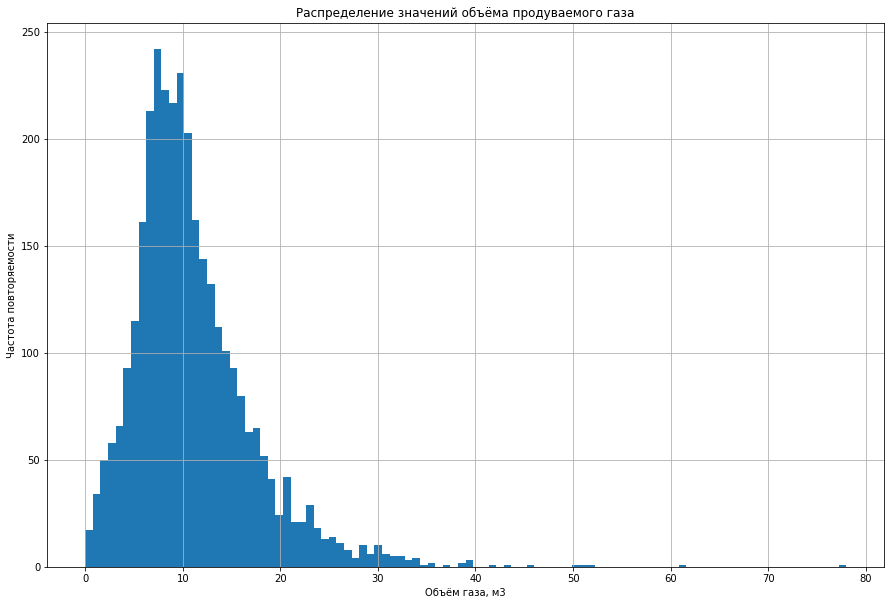

In [ ]:
gas_purge['Газ 1'].hist(bins=100, figsize=(15,10))
plt.title('Распределение значений объёма продуваемого газа')
plt.xlabel('Объём газа, м3')
plt.ylabel('Частота повторяемости')
plt.show()

Вполне нормальное. Длинный хвост вправо - редко повторяющиеся значения.

#### Промежуточные выводы по пункту 1.4

1. Загружен файл с данными об объёме продуваемого газа;
2. Рассмотрены несколько первых и последних строк файла;
3. Столбец проименованы по-русски, с заглавной буквы, с пробелами. Менять наименование пока не буду. Заказчика такой формат устраивает;
4. Пропусков и дубликатов не обнаружено;
5. Количество значений ключевого признака (key) - 3239.

### Результаты измерения температуры

In [ ]:
try:
    temp = pd.read_csv('/datasets/data_temp_new.csv')
except FileNotFoundError:
    temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

Загрузил файл. Теперь взгляну на несколько первых и последних строк.

In [ ]:
temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [ ]:
temp.tail()

,key,Время замера,Температура
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


Получу информацию о файле.

In [ ]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Есть пропуски. Чтобы не считать в уме, выведу на экран количество пропусков.

In [ ]:
temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

3427 пропусков. С чем может быть связано? Допустим, датчик не работал или не внесли, пропустили время замера. Временные промежутки замеров неравномерны.

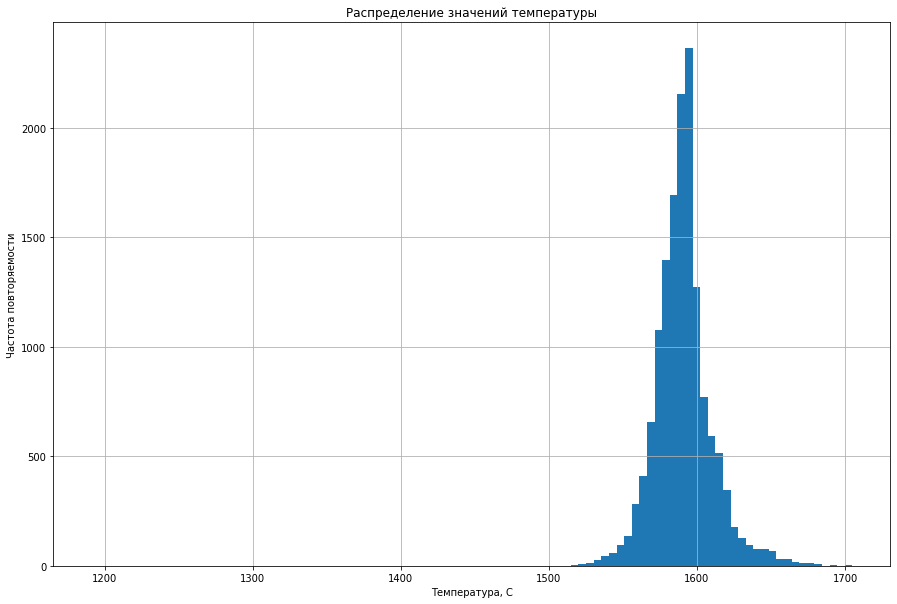

In [ ]:
temp['Температура'].hist(bins=100, figsize=(15,10))
plt.title('Распределение значений температуры')
plt.xlabel('Температура, C')
plt.ylabel('Частота повторяемости')
plt.show()

Прекрасно, но есть вылеты "влево", которые, похоже, незначительны.

#### Промежуточные выводы по пункту 1.5

1. Загружен файл с данными о температуре;
2. Рассмотрены несколько первых и последних строк файла;
3. Столбцы проименованы по-русски, с заглавной буквы, с пробелами. Менять наименование пока не буду. Заказчика такой формат устраивает;
4. 3427 пропусков в столбце "Температура" (отстутствие замеров по различным причинам);
5. Количество значений ключевого признака (key) аналогично файлу данных об электродах - 3241;
6. Дубликатов не обнаружено.

### Данные о проволочных материалах (объём)

In [ ]:
try:
    wire_bulk = pd.read_csv('/datasets/data_wire_new.csv')
except FileNotFoundError:
    wire_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

Загрузил файл. Теперь взгляну на несколько первых и последних строк.

In [ ]:
wire_bulk.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wire_bulk.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получу информацию о файле.

In [ ]:
wire_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Посчитаю пропуски и проранжирую столбцы по ним.

In [ ]:
wire_bulk.isna().sum().sort_values(ascending=False)

Wire 5    3080
Wire 7    3070
Wire 4    3067
Wire 8    3062
Wire 9    3052
Wire 3    3018
Wire 6    3008
Wire 2    2002
Wire 1      26
key          0
dtype: int64

Здесь, я думаю, объяснить пропуски проще всего. Подаётся проволока преимущественно одного конкретного типа. В редких случаях используются другие легирующие компоненты.

Проверю на дубликаты.

In [ ]:
wire_bulk.duplicated().sum()

0

#### Промежуточные выводы по пункту 1.6

1. Загружен файл с данными об объёме проволочных материалов;
2. Рассмотрены несколько первых и последних строк файла;
3. Столбцы проименованы по-английски, с заглавной буквы, с пробелами Менять наименование пока не буду. Заказчика такой формат устраивает;
3. Пропуски обнаружены во всех столбцах. Их наличие позволяет увидеть, что наиболее часто в качестве легирующей добавки применяется тип проволоки Wire 1;
4. Дубликатов не обнаружено.
5. Ключевых признаков (key) в файле совпадает с данными об электродах и температуре.

### Данные о проволочных материалах (время)

In [ ]:
try:
    wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except FileNotFoundError:
    wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

Загрузил файл. Теперь взгляну на несколько первых и последних строк.

In [ ]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wire_time.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получу информацию о файле. Полагаю, что картина по пропускам будет сходна с файлом объёмов проволоки.

In [ ]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Посчитаю пропуски и проранжирую столбцы по ним.

In [ ]:
wire_time.isna().sum().sort_values(ascending=False)

Wire 5    3080
Wire 7    3070
Wire 4    3067
Wire 8    3062
Wire 9    3052
Wire 3    3018
Wire 6    3008
Wire 2    2002
Wire 1      26
key          0
dtype: int64

Всё логично. 2 файла касаются одного процесса, поэтому и количество пропусков в них одинаковое.

Проверю на дубликаты.

In [ ]:
wire_time.duplicated().sum()

0

In [ ]:
wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


#### Промежуточные выводы по пункту 1.7

1. Загружен файл с данными о времени подачи проволочных материалов;
2. Рассмотрены несколько первых и последних строк файла;
3. Столбцы проименованы по-английски, с заглавной буквы, с пробелами Менять наименование пока не буду. Заказчика такой формат устраивает;
3. Пропуски обнаружены во всех столбцах. Аналогичны файлу с объёмами проволки;
4. Дубликатов не обнаружено.
5. Ключевых признаков (key) в файле 3081.

### Выводы по пункту 1

1. Загружены все 7 файлов с данными;
2. Проведён их предварительный осмотр. Большая часть данных имеет пропуски. Пары файлов, относящиеся к одному процессу (пара файлов о сыпучих материалов и пара файлов о проволочных материалах) имеют одинаковое число пропусков;
3. Различное количество пропусков в файлах говорит о том, что при объединении результирующий файл будет иметь "пустые" места.
4. В файле данных об электродах необходимо удалить строку с отрицательным значением реактивной мощности;
5. Пропуски в файлах о сыпучих материалах необходимо заполнить нулями;
6. Дубликатов ни в одном из дата-файлов не обнаружено;
7. Распределение признаков в файлах, где признак один носит характер распределения, близкий к нормальному;
8. Столбцы имеют различное наименование. Для удобства я переведу все имена на русский язык (кроме key, который, как я понимаю, нужен только для объединения таблиц);
9. Данные по времени приведу к формату дата-время.

## Исcледовательский анализ и предобработка данных

### Преобразование формата даты

In [ ]:
try:
    arcs['Начало нагрева дугой'] = pd.to_datetime(arcs['Начало нагрева дугой'],format='%Y-%m-%dT%H:%M:%S')
    arcs['Конец нагрева дугой'] = pd.to_datetime(arcs['Конец нагрева дугой'],format='%Y-%m-%dT%H:%M:%S')
    temp['Время замера'] = pd.to_datetime(temp['Время замера'],format='%Y-%m-%dT%H:%M:%S')
    print('перевели')
except:
    print('не получилось')

перевели


In [ ]:
arcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Сделал. Теперь переименование столбцов.

### Переименование столбцов

In [ ]:
bulk.columns = ['key', 'Объём 1','Объём 2','Объём 3','Объём 4','Объём 5','Объём 6','Объём 7','Объём 8',
                     'Объём 9','Объём 10','Объём 11','Объём 12','Объём 13','Объём 14','Объём 15']
time.columns = ['key', 'Объём 1','Объём 2','Объём 3','Объём 4','Объём 5','Объём 6','Объём 7','Объём 8',
                     'Объём 9','Объём 10','Объём 11','Объём 12','Объём 13','Объём 14','Объём 15']
wire_bulk.columns = ['key','Проволока 1','Проволока 2','Проволока 3','Проволока 4','Проволока 5',
                     'Проволока 6','Проволока 7','Проволока 8','Проволока 9']
wire_time.columns = ['key','Проволока 1','Проволока 2','Проволока 3','Проволока 4','Проволока 5',
                     'Проволока 6','Проволока 7','Проволока 8','Проволока 9']

In [ ]:
bulk.head()

,key,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,Объём 6,Объём 7,Объём 8,Объём 9,Объём 10,Объём 11,Объём 12,Объём 13,Объём 14,Объём 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
time.head()

,key,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,Объём 6,Объём 7,Объём 8,Объём 9,Объём 10,Объём 11,Объём 12,Объём 13,Объём 14,Объём 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [ ]:
wire_bulk.head()

,key,Проволока 1,Проволока 2,Проволока 3,Проволока 4,Проволока 5,Проволока 6,Проволока 7,Проволока 8,Проволока 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wire_time.head()

,key,Проволока 1,Проволока 2,Проволока 3,Проволока 4,Проволока 5,Проволока 6,Проволока 7,Проволока 8,Проволока 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Как говорит один мой университетский препоадаватель, заборы покрасили, теперь к серьёзной работе.

### Заполнение пропусков

В файлах данных о сыпучих материалах заполню пропуски нулями.

Сначала файл с объёмами.

In [ ]:
bulk.fillna(0, inplace=True)

Проверяю.

In [ ]:
bulk.head()

,key,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,Объём 6,Объём 7,Объём 8,Объём 9,Объём 10,Объём 11,Объём 12,Объём 13,Объём 14,Объём 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Теперь файл со временем.

In [ ]:
time.fillna(0, inplace=True)

In [ ]:
time.head()

,key,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,Объём 6,Объём 7,Объём 8,Объём 9,Объём 10,Объём 11,Объём 12,Объём 13,Объём 14,Объём 15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


In [ ]:
wire_bulk.fillna(0, inplace=True)

In [ ]:
wire_bulk.head()

,key,Проволока 1,Проволока 2,Проволока 3,Проволока 4,Проволока 5,Проволока 6,Проволока 7,Проволока 8,Проволока 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Исключение отрицательной реактивной мощности в данных об электродах

Помним ту самую одну строчку. Удалю её.

In [ ]:
arcs = arcs.drop(arcs[arcs['Реактивная мощность'] <= 0].index).reset_index(drop=True)

Проверю, не осталось ли ещё неожиданных значений.

In [ ]:
arcs[arcs['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


Попробую вывести гистограмму распределения.

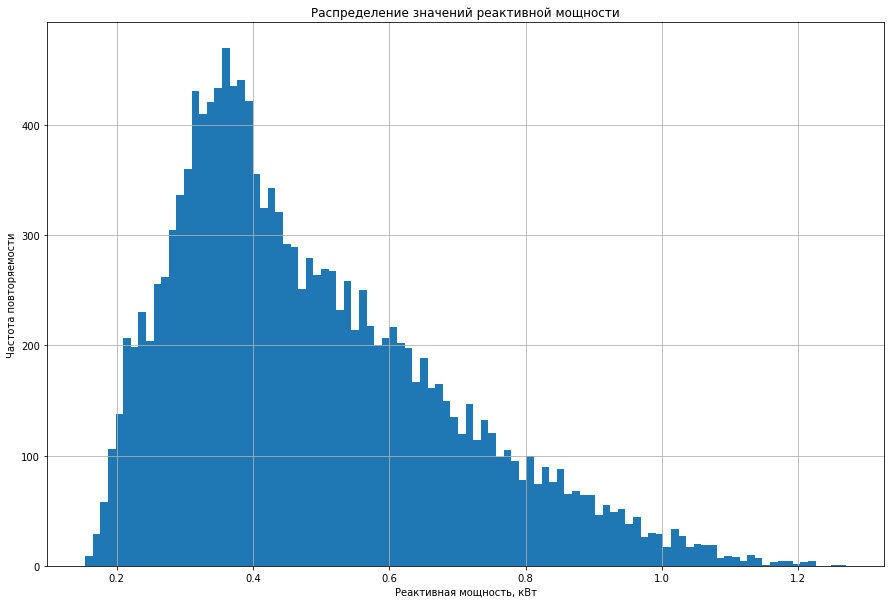

In [ ]:
arcs['Реактивная мощность'].hist(bins=100, figsize=(15,10))
plt.title('Распределение значений реактивной мощности')
plt.xlabel('Реактивная мощность, кВт')
plt.ylabel('Частота повторяемости')
plt.show()

Другое дело. Распределение, аналогичное активной мощности.

### Очищение данных температуры

Помня замечания куратора, на данном этапе удаля только температуры ниже 1500 и одиночные значения.

In [ ]:
low_temp = temp[temp['Температура'] <= 1500]['key'].unique()
temp = temp[~temp['key'].isin(low_temp)]
temp = temp.reset_index(drop=True)
temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18060,3241,2019-09-06 16:55:01,NaN
18061,3241,2019-09-06 17:06:38,NaN
18062,3241,2019-09-06 17:21:48,NaN
18063,3241,2019-09-06 17:24:44,NaN


Теперь ключи с одним замером температуры. Найду их.

In [ ]:
temp.groupby('key').filter(lambda x : len(x)==1)

,key,Время замера,Температура
1105,195,2019-05-11 00:01:36,1583.0
1549,279,2019-05-14 10:13:01,1603.0


Всего две строки. Удалю их грубым, некрасивым способом.

In [ ]:
temp = temp.drop(temp[temp['key'] == 195].index).reset_index(drop=True)

In [ ]:
temp = temp.drop(temp[temp['key'] == 279].index).reset_index(drop=True)

Проверю, не осталось ли чего ещё.

In [ ]:
temp.groupby('key').filter(lambda x : len(x)==1)

,key,Время замера,Температура


Всё чисто.

Теперь удалю промежуточные размеры температуры. Нам нужен первый и последний замер.

In [ ]:
def temp_begin_end(data):
    temp_new = pd.DataFrame()
    for key in data['key'].unique():
        new = data[data['key']==key].sort_values(by='Время замера')
        temp_new = temp_new.append(new.head(1))
        temp_new = temp_new.append(new.tail(1))
    return temp_new

temp = temp_begin_end(temp)

In [ ]:
temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
10,2,2019-05-03 11:55:09,1602.0
11,3,2019-05-03 12:06:44,1596.0
...,...,...,...
18050,3239,2019-09-06 15:09:55,NaN
18051,3240,2019-09-06 15:25:21,1617.0
18056,3240,2019-09-06 16:35:26,NaN
18057,3241,2019-09-06 16:48:55,1586.0


In [ ]:
nan = temp[temp['Температура'].isna()]['key'].unique()
temp = temp[~temp['key'].isin(nan)]

In [ ]:
temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
10,2,2019-05-03 11:55:09,1602.0
11,3,2019-05-03 12:06:44,1596.0
...,...,...,...
13891,2497,2019-08-10 12:53:28,1589.0
13892,2498,2019-08-10 12:58:11,1591.0
13897,2498,2019-08-10 13:23:31,1594.0
13898,2499,2019-08-10 13:33:21,1569.0


### Добавление данных

К имеющимся данным я добавлю свои признаки. В файл с данными об электродах добавлю столбец с временем нагрева, как разницу между концом и началом нагрева электродов.

In [ ]:
arcs['Время нагрева дугой'] = (arcs['Конец нагрева дугой'] - arcs['Начало нагрева дугой']).dt.seconds

Проверяю.

In [ ]:
arcs.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


В этот же файл, помня, что мощность - это работа или энергия, затраченная в единицу времени, я добавлю столбец с работой на нагрев.

In [ ]:
arcs['Работа на нагрев'] = arcs['Активная мощность'] * arcs['Время нагрева дугой']

Проверяю.

In [ ]:
arcs.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева дугой,Работа на нагрев
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,128.335684


Я предположил, что активная мощность дана в киловаттах, значит работа на нагрев должна получиться в килоджоулях.

Оставляю только стобец с работой на нагрев, т.к все остальные столбцы вошли в расчёт нового столбца.

In [ ]:
arcs = arcs.groupby('key').agg({'Работа на нагрев': sum})
arcs


,Работа на нагрев
key,
1,628.616930
2,395.281800
3,581.774624
4,543.710274
5,412.180480
...,...
3237,493.152191
3238,229.390861
3239,751.674870


In [ ]:
def delta (data):
    list = []

    for key in data['key'].unique():
        temper = data[data['key']==key].reset_index(drop=True)
        begin = temper.loc[0,'Температура']
        end = temper.loc[1,'Температура']
        diff = (temper.loc[1,'Время замера'] - temper.loc[0,'Время замера']).seconds

        list.append([key, begin, end, diff])

    return pd.DataFrame(list,
                        columns=['key',
                                 'Температура в начале',
                                 'Температура в конце',
                                 'Время между замерами'])

temp = delta(temp)
temp

,key,Температура в начале,Температура в конце,Время между замерами
0,1,1571.0,1613.0,1714
1,2,1581.0,1602.0,1265
2,3,1596.0,1599.0,1753
3,4,1601.0,1625.0,1220
4,5,1576.0,1602.0,1536
...,...,...,...,...
2466,2495,1570.0,1591.0,1380
2467,2496,1554.0,1591.0,1705
2468,2497,1571.0,1589.0,962
2469,2498,1591.0,1594.0,1520


### Выводы по пункту 2

1. Выполнено преобразование времени начала и конца нагрева электродов в формат datetime;
2. В файлах данных о сыпучих материалах и о проволоке наименование столбцов переведено на русский язык;
3. В файлах данных о сыпучих материалах пропуски заполнены нулями;
4. В файле данных об электродах удалена строка с отрицательной реактивной мощностью;
5. В файле данных температуры исключены строки с температурой меньше 1500 градусов и строки с одиночными замерами температуры;
6. В файл данных об электродах добавлены признаки времени нагрева и работы на нагрев, оставлена только работа на нагрев, как результирующий;
7. Файлы подготовлены к объединению.

## Объединение данных и исследовательский анализ и предобработка данных объединённого датафрейма

Исходя из поставленной задачи - предсказание температуры сплава, объединяю следующие файлы:
1. Данные об электродах;
2. Данные об объёме поданных сыпучих материалов;
3. Результаты замеров температуры;
4. Данные о продувке газом;
5. Данные об объёме проволочных материалов.

Временные данные о сыпучих материалах и проволоке я не включаю в объединённую таблицу. При построении модели это не пригодится.

In [ ]:
united = temp.merge(right= arcs,
                       how='inner',
                       on='key')\
                .merge(right= bulk,
                       how='inner',
                       on='key')\
                .merge(right=gas_purge,
                       how='inner',
                       on='key')\
                .merge(right=wire_bulk,
                       how='inner',
                       on='key')

In [ ]:
united.head()

,key,Температура в начале,Температура в конце,Время между замерами,Работа на нагрев,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,...,Газ 1,Проволока 1,Проволока 2,Проволока 3,Проволока 4,Проволока 5,Проволока 6,Проволока 7,Проволока 8,Проволока 9
0,1,1571.0,1613.0,1714,628.616930,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265,395.281800,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753,581.774624,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220,543.710274,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536,412.180480,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Получил единый датафрейм. Дальше работаю с ним.

In [ ]:
united.describe()

,key,Температура в начале,Температура в конце,Время между замерами,Работа на нагрев,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,...,Газ 1,Проволока 1,Проволока 2,Проволока 3,Проволока 4,Проволока 5,Проволока 6,Проволока 7,Проволока 8,Проволока 9
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,...,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,1587.365161,1593.366022,2323.419785,539.240396,3.433548,1.424946,47.296774,37.331613,2.644731,...,11.378942,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658
std,715.099053,23.623144,11.209581,1385.569302,257.335215,12.421994,19.098442,75.228262,58.670377,22.421296,...,6.395632,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510
min,1.000000,1519.000000,1541.000000,339.000000,26.187544,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008399,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,629.000000,1571.000000,1587.000000,1581.000000,368.206194,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.282948,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,1587.000000,1593.000000,2046.000000,508.453259,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.100950,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,1603.000000,1598.000000,2793.000000,679.062253,0.000000,0.000000,80.000000,77.000000,0.000000,...,14.217691,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,23674.000000,3718.054401,185.000000,325.000000,454.000000,281.000000,603.000000,...,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


In [ ]:
united.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   2325 non-null   int64  
 1   Температура в начале  2325 non-null   float64
 2   Температура в конце   2325 non-null   float64
 3   Время между замерами  2325 non-null   int64  
 4   Работа на нагрев      2325 non-null   float64
 5   Объём 1               2325 non-null   float64
 6   Объём 2               2325 non-null   float64
 7   Объём 3               2325 non-null   float64
 8   Объём 4               2325 non-null   float64
 9   Объём 5               2325 non-null   float64
 10  Объём 6               2325 non-null   float64
 11  Объём 7               2325 non-null   float64
 12  Объём 8               2325 non-null   float64
 13  Объём 9               2325 non-null   float64
 14  Объём 10              2325 non-null   float64
 15  Объём 11             

Проверю размерность.

In [ ]:
united

,key,Температура в начале,Температура в конце,Время между замерами,Работа на нагрев,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,...,Газ 1,Проволока 1,Проволока 2,Проволока 3,Проволока 4,Проволока 5,Проволока 6,Проволока 7,Проволока 8,Проволока 9
0,1,1571.0,1613.0,1714,628.616930,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265,395.281800,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753,581.774624,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220,543.710274,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536,412.180480,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,1380,571.539318,0.0,0.0,21.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,1554.0,1591.0,1705,675.222467,0.0,0.0,0.0,63.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,1571.0,1589.0,962,680.326674,0.0,0.0,0.0,85.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,1591.0,1594.0,1520,474.918795,0.0,0.0,90.0,0.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2325 строк. Подходит под условие, обозначенное ментором: не более 2332 ключей в объединённом файле.

Таблицы объединил, значит столбец 'key' больше не нужен.

In [ ]:
united.drop('key', axis= 1 , inplace= True)

In [ ]:
united

,Температура в начале,Температура в конце,Время между замерами,Работа на нагрев,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,Объём 6,...,Газ 1,Проволока 1,Проволока 2,Проволока 3,Проволока 4,Проволока 5,Проволока 6,Проволока 7,Проволока 8,Проволока 9
0,1571.0,1613.0,1714,628.616930,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,1265,395.281800,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,1753,581.774624,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,1220,543.710274,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,1536,412.180480,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,1570.0,1591.0,1380,571.539318,0.0,0.0,21.0,0.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2321,1554.0,1591.0,1705,675.222467,0.0,0.0,0.0,63.0,0.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,1571.0,1589.0,962,680.326674,0.0,0.0,0.0,85.0,0.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,1591.0,1594.0,1520,474.918795,0.0,0.0,90.0,0.0,0.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрю на столбцы объединённого файла. Если пропущено более 80% значений - удалю.

In [ ]:
united.isna().mean()*100

Температура в начале    0.0
Температура в конце     0.0
Время между замерами    0.0
Работа на нагрев        0.0
Объём 1                 0.0
Объём 2                 0.0
Объём 3                 0.0
Объём 4                 0.0
Объём 5                 0.0
Объём 6                 0.0
Объём 7                 0.0
Объём 8                 0.0
Объём 9                 0.0
Объём 10                0.0
Объём 11                0.0
Объём 12                0.0
Объём 13                0.0
Объём 14                0.0
Объём 15                0.0
Газ 1                   0.0
Проволока 1             0.0
Проволока 2             0.0
Проволока 3             0.0
Проволока 4             0.0
Проволока 5             0.0
Проволока 6             0.0
Проволока 7             0.0
Проволока 8             0.0
Проволока 9             0.0
dtype: float64

Теперь построю графики всех признаков в объединённом файле.

array([[<AxesSubplot:title={'center':'Температура в начале'}>,
        <AxesSubplot:title={'center':'Температура в конце'}>,
        <AxesSubplot:title={'center':'Время между замерами'}>,
        <AxesSubplot:title={'center':'Работа на нагрев'}>,
        <AxesSubplot:title={'center':'Объём 1'}>],
       [<AxesSubplot:title={'center':'Объём 2'}>,
        <AxesSubplot:title={'center':'Объём 3'}>,
        <AxesSubplot:title={'center':'Объём 4'}>,
        <AxesSubplot:title={'center':'Объём 5'}>,
        <AxesSubplot:title={'center':'Объём 6'}>],
       [<AxesSubplot:title={'center':'Объём 7'}>,
        <AxesSubplot:title={'center':'Объём 8'}>,
        <AxesSubplot:title={'center':'Объём 9'}>,
        <AxesSubplot:title={'center':'Объём 10'}>,
        <AxesSubplot:title={'center':'Объём 11'}>],
       [<AxesSubplot:title={'center':'Объём 12'}>,
        <AxesSubplot:title={'center':'Объём 13'}>,
        <AxesSubplot:title={'center':'Объём 14'}>,
        <AxesSubplot:title={'center':'Объём 1

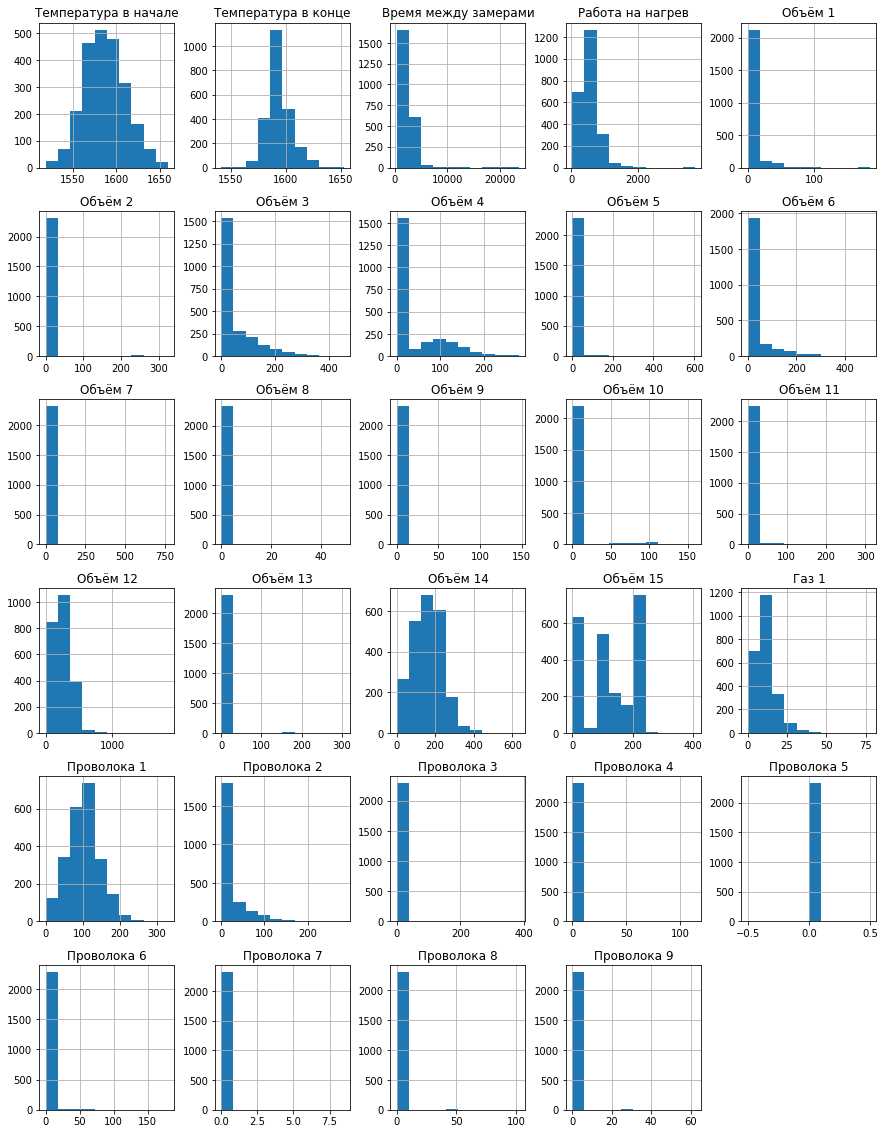

In [ ]:
united.hist(figsize=(15,20))

Как и проверяли ранее, некоторые сыпучие компоненты и проволоки используются чуть чаще, чем никогда. Но я их оставлю.

Удалю откровенно пустой столбец с данными о проволоке 5. Остальные оставлю. Всё же, это не пропуски. Просто чаще всего используется проволока 1, остальные - мало.

In [ ]:
united.drop('Проволока 5', axis= 1 , inplace= True)

Выведу тепловую карту корреляций всех признаков.

Text(0.5, 1.0, 'Тепловая карта корреляций')

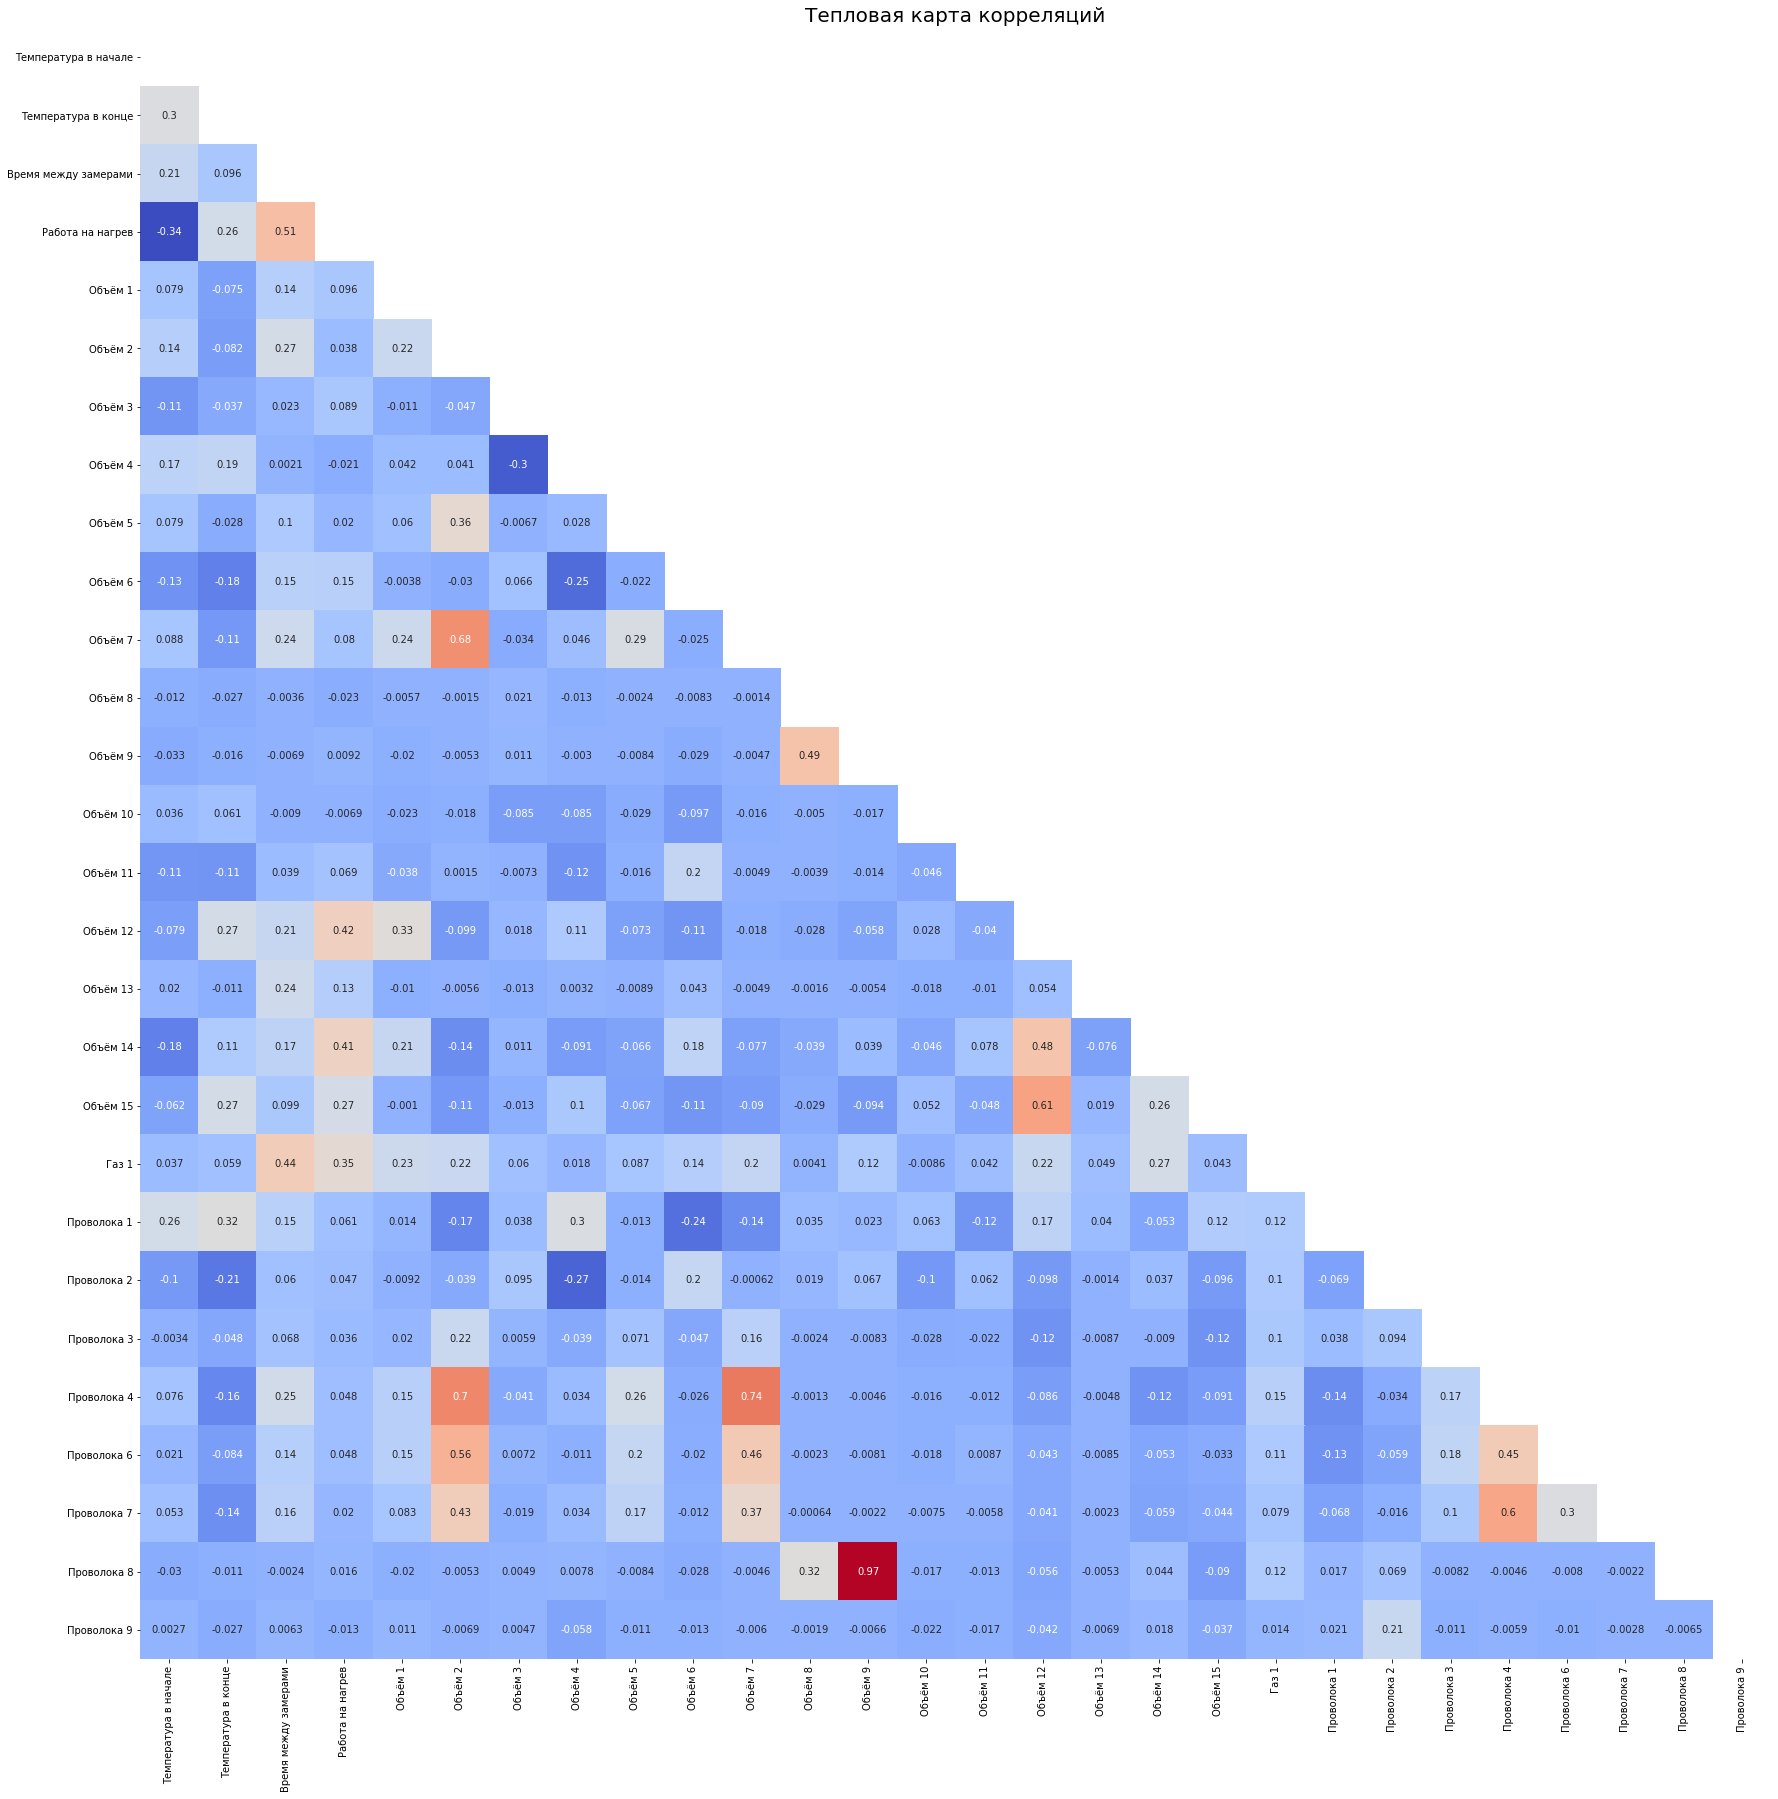

In [ ]:
plt.figure(figsize=(30, 30))
total_map = np.triu(united.corr())
heatmap = sb.heatmap(united.corr(),annot=True, mask=total_map,square=True,cmap='coolwarm', cbar=False, fmt='.2g')
heatmap.set_title('Тепловая карта корреляций', fontsize=20)

Видно яркие "пятна" существенной корреляции между, к примеру временем между замерами и проволокой 8, нескольких объёма сыпучего материала и проволоки 8.

В поставленной задаче ключевым является признак - Температура в конце. Поэтому выведу отдельно корреляцию для него.

In [ ]:
united.corr()['Температура в конце'].sort_values(ascending=False)[1:]

Проволока 1             0.317702
Температура в начале    0.301961
Объём 12                0.267379
Объём 15                0.266386
Работа на нагрев        0.258418
Объём 4                 0.188100
Объём 14                0.114520
Время между замерами    0.096342
Объём 10                0.061345
Газ 1                   0.059036
Проволока 8            -0.010772
Объём 13               -0.010925
Объём 9                -0.016081
Объём 8                -0.026590
Проволока 9            -0.027496
Объём 5                -0.028365
Объём 3                -0.036767
Проволока 3            -0.047548
Объём 1                -0.075233
Объём 2                -0.082466
Проволока 6            -0.084049
Объём 7                -0.107289
Объём 11               -0.114777
Проволока 7            -0.137275
Проволока 4            -0.159737
Объём 6                -0.181880
Проволока 2            -0.206837
Name: Температура в конце, dtype: float64

Пятёрка лидеров:
1. Проволока 1 -            0.312223;
2. Температура в начале -   0.301961;
3. Объём 12 -               0.267379;
4. Объём 15 -               0.266386;
5. Работа на нагрев -       0.258418.

Логично. Но корреляция в то же время не абсолютная.

"Аутсайдеры" - проволоки 7, 4, 5. Для них вообще почти обратная взаимосвязь с температурой в конце.

### Выводы по пункту 3

1. В единый файл объединены следующие таблицы:
- Данные об электродах;
- Данные об объёме поданных сыпучих материалов;
- Результаты замеров температуры;
- Данные о продувке газом;
- Данные об объёме проволочных материалов.
2. Удалён признак "Проволока 5", т.к он был абсолютно пустым;
3. Для определения корреляции между признаками построена тепловая карта;
4. Наибольшей корреляцией с целевым признаком "Температура в конце" обладают:
- Проволока 1 - 0.312223;
- Температура в начале - 0.301961;
- Объём 12 - 0.267379;
- Объём 15 - 0.266386;
- Работа на нагрев - 0.258418.

Далее подготовлю выборки для модели.

## Подготовка данных

Объявлю признаки и целевой признак.

In [ ]:
features = united.drop(['Температура в конце'], axis=1)
target = united ['Температура в конце']

Разделяю на тренировочную и тестовую в соотношении 3:1.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25,
                                                                            random_state=RANDOM_STATE)

Проверю размер обучающей выборки.

In [ ]:
features_train.shape

(1743, 27)

Отлично. Более 1700.

Выборки готовы. Приступаю к обучению моделей.

## Обучение моделей машинного обучения

### Обучение модели линейной регрессии

Взгляну на выборку

In [ ]:
features_train.head()

,Температура в начале,Время между замерами,Работа на нагрев,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,Объём 6,Объём 7,...,Объём 15,Газ 1,Проволока 1,Проволока 2,Проволока 3,Проволока 4,Проволока 6,Проволока 7,Проволока 8,Проволока 9
534,1619.0,3576,489.485309,0.0,0.0,55.0,0.0,0.0,0.0,0.0,...,153.0,26.295454,103.194001,12.124320,0.0,0.0,0.0,0.0,0.0,0.0
1036,1595.0,1568,504.761263,0.0,0.0,23.0,0.0,0.0,0.0,0.0,...,102.0,5.810964,86.065193,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
243,1568.0,6883,1232.208658,0.0,0.0,226.0,0.0,0.0,0.0,0.0,...,204.0,5.583702,171.924481,19.190081,0.0,0.0,0.0,0.0,0.0,0.0
2038,1565.0,1547,626.445786,0.0,0.0,46.0,0.0,0.0,0.0,0.0,...,213.0,15.608966,100.070877,25.093119,0.0,0.0,0.0,0.0,0.0,0.0
1515,1564.0,1072,730.721831,0.0,0.0,83.0,0.0,0.0,0.0,0.0,...,203.0,5.557812,101.087997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Для линейной регрессии удалю высококоррелированный признак - Проволока 8.

In [ ]:
features_train_linreg = features_train.drop(['Проволока 8'], axis=1)

In [ ]:
scaled_columns = ['Температура в начале', 'Время между замерами', 'Работа на нагрев']

scaler = StandardScaler()
scaler.fit(features_train[scaled_columns])

StandardScaler()

In [ ]:
features_train_linreg[scaled_columns] = scaler.transform(features_train_linreg[scaled_columns])
features_train_linreg.head()

,Температура в начале,Время между замерами,Работа на нагрев,Объём 1,Объём 2,Объём 3,Объём 4,Объём 5,Объём 6,Объём 7,...,Объём 14,Объём 15,Газ 1,Проволока 1,Проволока 2,Проволока 3,Проволока 4,Проволока 6,Проволока 7,Проволока 9
534,1.334842,0.855434,-0.207139,0.0,0.0,55.0,0.0,0.0,0.0,0.0,...,160.0,153.0,26.295454,103.194001,12.124320,0.0,0.0,0.0,0.0,0.0
1036,0.332776,-0.524699,-0.148629,0.0,0.0,23.0,0.0,0.0,0.0,0.0,...,102.0,102.0,5.810964,86.065193,0.000000,0.0,0.0,0.0,0.0,0.0
243,-0.794548,3.128393,2.637630,0.0,0.0,226.0,0.0,0.0,0.0,0.0,...,103.0,204.0,5.583702,171.924481,19.190081,0.0,0.0,0.0,0.0,0.0
2038,-0.919806,-0.539132,0.317445,0.0,0.0,46.0,0.0,0.0,0.0,0.0,...,213.0,213.0,15.608966,100.070877,25.093119,0.0,0.0,0.0,0.0,0.0
1515,-0.961559,-0.865608,0.716842,0.0,0.0,83.0,0.0,0.0,0.0,0.0,...,129.0,203.0,5.557812,101.087997,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
%%time

linreg = LinearRegression()
print('# Train for mean_absolute_error')
print()
MAE_linreg = (cross_val_score(linreg, features_train_linreg, target_train, cv=cv_counts,
                             scoring='neg_mean_absolute_error').mean() * -1)

print('Средняя абсолютная ошибка для линейной регрессии =', MAE_linreg)
print()

# Train for mean_absolute_error

Средняя абсолютная ошибка для линейной регрессии = 6.745754674055645

CPU times: user 93.4 ms, sys: 90.9 ms, total: 184 ms
Wall time: 92.1 ms


6,746. Вариант приемлемый, соответствует "Нормально". Проверим другие модели.

### Обучение модели случайный лес

In [ ]:
%%time

forest = RandomForestRegressor()
hypers = [{'criterion':['mae'], 'n_estimators':[x for x in range(50, 300, 50)], 'random_state':[RANDOM_STATE]}]

print('Подбор гиперпараметров для расчёта среднеквадратичной ошибки')
print()
forest_cv = GridSearchCV(forest, hypers, scoring='neg_mean_absolute_error', cv=cv_counts)
forest_cv.fit(features_train, target_train)
print("Лучшие параметры")
print()
best_params_forest = forest_cv.best_params_
print(forest_cv.best_params_)
best_score_forest = forest_cv.best_score_
print(forest_cv.best_score_)
print()
print("Получилось:")
print()
means = forest_cv.cv_results_['mean_test_score']
stds = forest_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, forest_cv.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

MAE_forest = (max(means)*-1)
print('Средняя абсолютная ошибка для случайного леса =', MAE_forest)
print()

Подбор гиперпараметров для расчёта среднеквадратичной ошибки

Лучшие параметры

{'criterion': 'mae', 'n_estimators': 100, 'random_state': 131123}
-6.555196357408687

Получилось:

6.557959 for {'criterion': 'mae', 'n_estimators': 50, 'random_state': 131123}
6.555196 for {'criterion': 'mae', 'n_estimators': 100, 'random_state': 131123}
6.564681 for {'criterion': 'mae', 'n_estimators': 150, 'random_state': 131123}
6.570208 for {'criterion': 'mae', 'n_estimators': 200, 'random_state': 131123}
6.574195 for {'criterion': 'mae', 'n_estimators': 250, 'random_state': 131123}

Средняя абсолютная ошибка для случайного леса = 6.555196357408687

CPU times: user 18min 46s, sys: 137 ms, total: 18min 46s
Wall time: 18min 48s


Лес, как всегда, довольно долго считается. Ошибка 6,56 - меньше, чем для линейной регрессии.

### Обучение модели категориального бустинга

In [ ]:
%%time
cb = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)

MAE_cb = (cross_val_score(cb, features_train, target_train, cv=cv_counts,
                           scoring='neg_mean_absolute_error').mean() * -1)

params_cb = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE).fit(features_train, target_train).\
                               get_all_params()

print('Параметры:', params_cb)
print()

print('Средняя абсолютная ошибка для модели категориального бустинга =', MAE_cb)
print()

Параметры: {'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 131123, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 0.04470000043511391, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_est

Ещё лучше - 6,47. Перехожу к следующей модели.

### Обучение модели лёгкой машины градиентного бустинга

In [ ]:
%%time

light = LGBMRegressor()
light_params = [{'num_leaves':[x for x in range(10,38, 5)], 'learning_rate':[x/100 for x in range(1, 11)],
                'random_state':[RANDOM_STATE]}]

light_cv = GridSearchCV(light, light_params, scoring='neg_mean_absolute_error', cv=cv_counts)

light_cv.fit(features_train, target_train)

print('Параметры:', light_cv.best_params_)
print()

print('Мера:', light_cv.best_score_)
print()

MAE_light = (max(light_cv.cv_results_['mean_test_score'])*-1)
print('Средняя абсолютная ошибка для модели лёгкой машины =', MAE_light)
print()

Параметры: {'learning_rate': 0.09, 'num_leaves': 10, 'random_state': 131123}

Мера: -6.437715493890693

Средняя абсолютная ошибка для модели лёгкой машины = 6.437715493890693

CPU times: user 4min 20s, sys: 4.87 s, total: 4min 24s
Wall time: 4min 26s


Теперь на первом месте после линейной регрессии модель лёгкой машины! Среднеквадратичная ошибка = 6,43.

### Свод результатов обучения моделей

Построю сводную таблицу, куда внесу значения среднеквадратических ошибок для обученных моделей.

In [ ]:
index = ['Линейная регрессия','Случайный лес','Категориальный бустинг','Лёгкая машина']

data = {'Средняя абсолютная ошибка на обучающей выборке': [MAE_linreg, MAE_forest, MAE_cb, MAE_light]}

coeff = pd.DataFrame(data=data, index=index)

coeff.sort_values(by='Средняя абсолютная ошибка на обучающей выборке', ascending=False)

,Средняя абсолютная ошибка на обучающей выборке
Линейная регрессия,6.745755
Случайный лес,6.555196
Категориальный бустинг,6.472641
Лёгкая машина,6.437715


### Вывод по пункту 5

Рассмотрено 5 моделей:
- Линейная регрессия;
- Случайный лес;
- Категориальный бустинг;
- Лёгкая машина градиентного бустинга.

Обучение показало, что из рассмотренных моделей наименьшее значение среднеквадратичной ошибки у модели лёгкой машины - 6,43. Она и будет обучена на тестовой выборке. Следует отметить, что все рассмотренные модели уложились в установленные рамки - значение MAE не более 6,8.

## Лучшая модель

### Обучение лучшей модели на тестовой выборке

Для лучшей модели - модели лёгкой машины - рассчитаю среднеквадратичную ошибку и дополнительно метрику R2 - коэффициент детерминации.

In [ ]:
light = LGBMRegressor()
light.set_params(**light_cv.best_params_)
light.fit(features_train, target_train)
predict = light.predict(features_test)


MAE_light_test = mean_absolute_error(target_test, predict)
r2_light_test = r2_score(target_test, predict)
print('Средняя абсолютная ошибка для полиномиальной регрессии =', MAE_light_test)
print("Коэффициент детерминации для полиномиальной регрессии = ", r2_light_test)
print()

Средняя абсолютная ошибка для полиномиальной регрессии = 6.651036510985221
Коэффициент детерминации для полиномиальной регрессии =  0.3697155237896701



###### Итак, обучение модели полиномиальной регрессии на тестовой выборке показало следующие результаты:
1. Среднеквадратичная ошибка (МАЕ) = 6,651;
2. Коэффициент детерминации (R2) = 0,369.

Значение коэффициента детерминации говорит о том, что 36,9% изменчивости зависимого выходного атрибута может быть объяснено моделью, в то время как остальные 63,1% изменчивости все еще не учтены.
Низкий показатель. Скорее всего, модель не достаточно очищена от выбросов.

### Проверка лучшей модели на адекватность

Применим dummyregressor.

In [ ]:
for testing in ['mean']:
    dummy = DummyRegressor(strategy=testing)
    dummy.fit(features_train, target_train)
    predict = dummy.predict(features_test)
    MAE_dummy = mean_absolute_error(target_test, predict)
    print('Для стратегии', testing, 'Средняя абсолютная ошибка -', MAE_dummy)

Для стратегии mean Средняя абсолютная ошибка - 8.14740947097175


Значение для константной модели выше - наша модель вполне адекватна.

### Факторный анализ лучшей модели (анализ значимости параметров)

Применю модуль shap. Поскольку с pipeline он не работает, применю его просто к линейной регрессии.

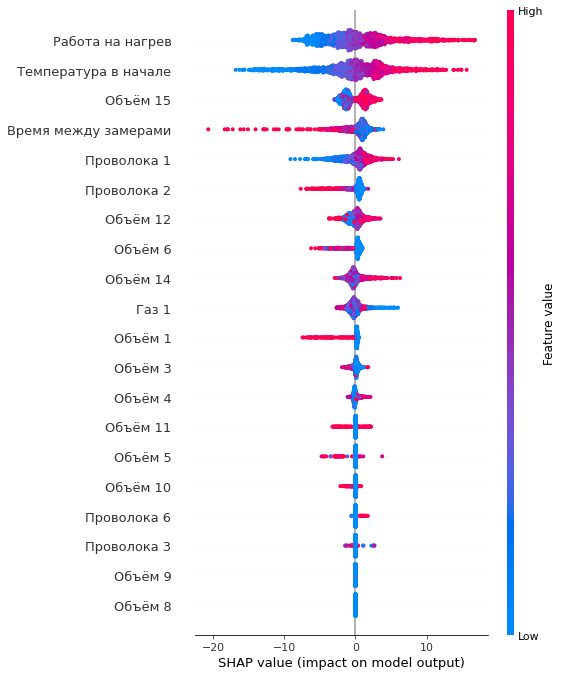

In [ ]:
light = LGBMRegressor()
light.fit(features_train, target_train)

shap_values = shap.TreeExplainer(light).shap_values(features_train)
shap.summary_plot(shap_values, features_train)

Значение слева от вертикальной оси - negative class, справа - positive. Чем толще линия на графике, тем больше таких точек наблюдения. Чем краснее точка, тем больше проявлено значение признака.

Немножко порассуждаем. Ключевой признак - температура в конце. Рассмотрим самый верхний признак - работа на нагрев.

Если верно читаю диаграмму, то чем меньше работа на нагрев, то есть, чем меньше энергии затрачено на нагрев, тем температу в конце ниже. Абсолютно логично.

Аналогично с температурой в начале. Чем она ниже, тем (при прочих равных) конечная температура ниже. Тоже всё просто.

При внесении сыпучего вещества 1 (Объём 1) температура в конце падает. Видимо, какое-то легкоплавкое вещество...

В итоге, на вершине рейтинга значимости у меня следующие признаки:
1. Работа на нагрев;
2. Температура в начале;
3. Объём 15 (сыпучее вещество 15);
4. Время между замерами;
5. Проволока 1 (легирующий материал 1).

### Выводы по пункту 6

1. Лучшая модель - модель полиномиальной регрессии, обученная на тестовой выборке, показала следующие результаты:
- Среднеквадратичная ошибка МАЕ = 6,651;
- Коэффициент детерминации R2 = 0,369 (модель низкого качества).
2. Проверка с помощью DummyRegressor показала адекватность модели;
3. Анализ значимости признаков показал, что самыми значимыми признаками являются:
- Работа на нагрев;
- Температура в начале;
- Объём 15 (сыпучее вещество 15);
- Время между замерами;
- Проволока 1 (легирующий материал 1).

## Общий вывод и рекомендации заказчику

Для достижения цели проекта сделаны следующие шаги:
1. Загружены все 7 файлов с данными;
2. Проведён их предварительный осмотр. Большая часть данных имеет пропуски. Пары файлов, относящиеся к одному процессу (пара файлов о сыпучих материалов и пара файлов о проволочных материалах) имеют одинаковое число пропусков;
3. Различное количество пропусков в файлах говорит о том, что при объединении результирующий файл будет иметь "пустые" места.
4. В файле данных об электродах необходимо удалить строку с отрицательным значением реактивной мощности;
5. Пропуски в файлах о сыпучих материалах необходимо заполнить нулями;
6. Дубликатов ни в одном из дата-файлов не обнаружено;
7. Распределение признаков в файлах, где признак один носит характер распределения, близкий к нормальному;
8. Столбцы имеют различное наименование. Для удобства я переведу все имена на русский язык (кроме key, который, как я понимаю, нужен только для объединения таблиц);
9. Данные по времени приведу к формату дата-время;
10. Выполнено преобразование времени начала и конца нагрева электродов в формат datetime;
11. В файлах данных о сыпучих материалах и о проволоке наименование столбцов переведено на русский язык;
12. В файлах данных о сыпучих материалах пропуски заполнены нулями;
13. В файле данных об электродах удалена строка с отрицательной реактивной мощностью;
14. В файле данных температуры исключены строки с температурой меньше 1500 градусов и строки с одиночными замерами температуры;
15. В файл данных об электродах добавлены признаки времени нагрева и работы на нагрев;
16. Файлы подготовлены к объединению;
17. В единый файл объединены следующие таблицы:
- Данные об электродах;
- Данные об объёме поданных сыпучих материалов;
- Результаты замеров температуры;
- Данные о продувке газом;
- Данные об объёме проволочных материалов.
18. Удалён признак "Проволока 5", т.к он был абсолютно пустым;
19. Для определения корреляции между признаками построена тепловая карта;
20. Наибольшей корреляцией с целевым признаком "Температура в конце" обладают:
- Проволока 1 - 0.312223;
- Температура в начале - 0.301961;
- Объём 12 - 0.267379;
- Объём 15 - 0.266386;
- Работа на нагрев - 0.258418.
21. На основе объединённого файла подготовлены обучающая и тестовая выборки;
22. Рассмотрено 4 модели:
- Случайный лес;
- Категориальный бустинг;
- Модель лёгкой машины градиентого бустинга;
- Линейная регрессия.

Обучение показало, что из рассмотренных моделей наименьшее значение среднеквадратичной ошибки у модели лёгкой машины - 6,438. Она и будет обучена на тестовой выборке. Следует отметить, что все рассмотренные модели уложились в установленные рамки - значение MAE не более 6,8.
23. Лучшая модель - модель полиномиальной регрессии, обученная на тестовой выборке, показала следующие результаты:
- Среднеквадратичная ошибка МАЕ = 6,651;
- Коэффициент детерминации R2 = 0,369 (модель среднего качества).
24. Проверка с помощью DummyRegressor показала адекватность модели;
25. Анализ значимости признаков показал, что самыми значимыми признаками являются:
- Работа на нагрев;
- Температура в начале;
- Объём 15 (сыпучее вещество 15)
- Время между замерами;
- Проволока 1 (легирующий материал 1).

Итого, получаем, что построенная модель - модель категориального бустинга способная предсказывать температуру в конце с точностью 6,4 градуса. В качестве рекомендации заказчику предоставлен анализ значимости признаков, участвующих в расчёте. Рекомендуется следить за начальной температурой сплава перед нагревом и энергией, которая тратится на нагрев. В качестве легирующего материала использовать "Проволока 1". Контролировать внесение сыпучих материалов, огазывающих негативное влияние на конечную температуру.

# Итоговый отчёт

1. В задании к проекту обозначен план работы:
- Загрузка данных;
- Исследовательский анализ и предобработка данных;
- Объединение данных;
- Исследовательский анализ и предобработка данных объединённого датафрейма;
- Подготовка данных;
- Обучение моделей машинного обучения;
- Выбор лучшей модели;
- Общий вывод и рекомендации заказчику.

Все пункты плана выполнены. Сверх этого был выполнен анализ значимости для предсказания признаков, участвующих в модели.

2. Ключевые шаги проекта.
Безусловно, это подготовка предоставленных данных (здесь я имею ввиду и предобработку и анализ и объединение), что повлияло на качество предсказания моделей и, собственно, само обучение моделей. Обучено 5 моделей. На тестовой выборке протестирована модель с наилучшим показателем МАЕ по итогам обучения.

3. Лучшая модель и её качество.

По итогам обучения лучшей моделью стала модель полиномиальной депрессии с МАЕ = 5,465. Предсказание на тестовой выборке дало результат 4,938. Дополнительно рассчитана метрика R2 (коэффициент детерминации) = 0,665, что говорит о среднем качестве модели. В качестве рекомендации заказчику предоставлен анализ значимости признаков, участвующих в расчёте. Рекомендуется следить за начальной температурой сплава перед нагревом и энергией, которая тратится на нагрев. В качестве легирующего материала использовать "Проволока 1". Контролировать внесение сыпучих материалов, огазывающих негативное влияние на конечную температуру.